In [3]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 2: Load and prepare the data
# Read the Excel file (skipping the first 12 rows)
df = pd.read_excel('CPI_monthly_2025_changes.xlsx', skiprows=11)
print(df.shape)
# Display the first 5 rows of the dataframe
print(df.head())


(1344, 4)
     Series ID  Year Period  Value
0  CUUR0000SA0  1913    M02    0.0
1  CUUR0000SA0  1913    M03    0.0
2  CUUR0000SA0  1913    M04    0.0
3  CUUR0000SA0  1913    M05   -1.0
4  CUUR0000SA0  1913    M06    1.0


c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Holt-Winters Performance:
RMSE: 0.14017532416372103
MAE: 0.10273095743898601


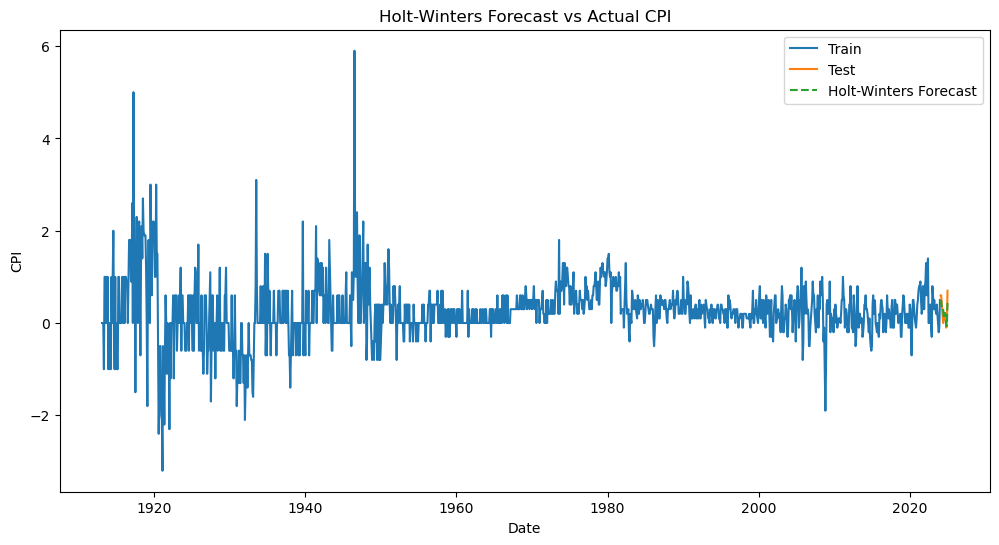

c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Performance:
RMSE: 0.1648357090813521
MAE: 0.1254544270981277


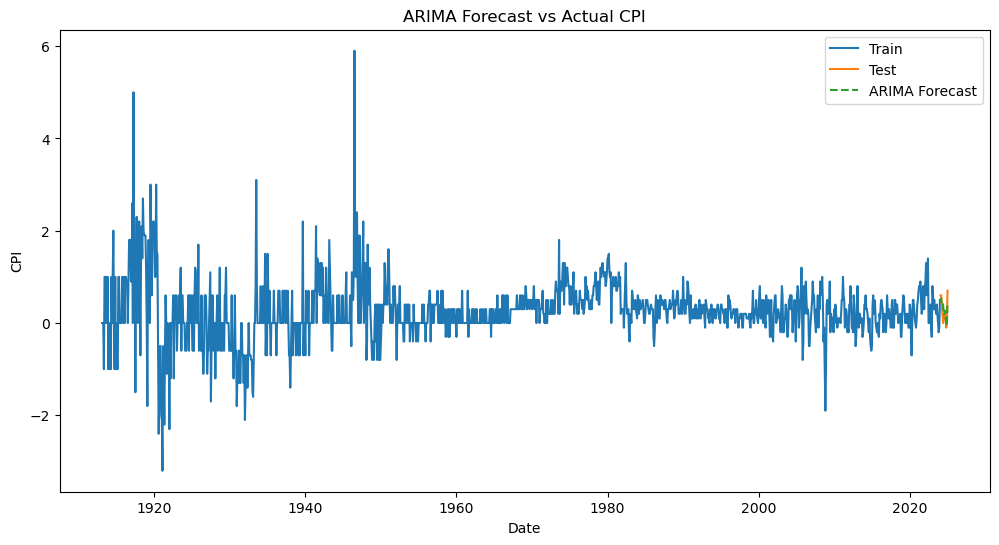

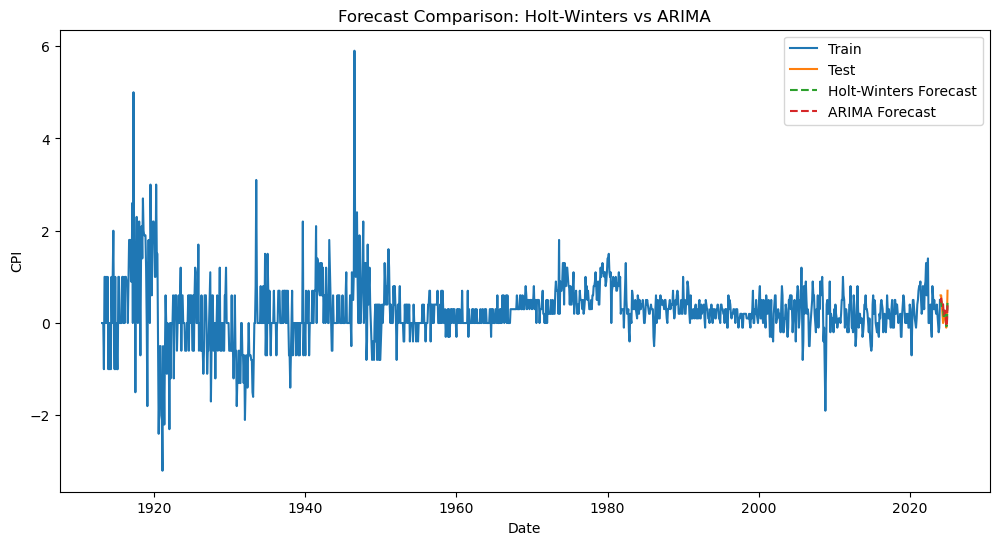

In [5]:
# Create the 'Date' column from 'Year' and 'Period'
# Assumes 'Period' values like 'M01', 'M02', etc.
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Period'].str[1:] + '-01')

# Optionally, if you need to filter rows where Period doesn't start with 'M'
df = df[df['Period'].str.startswith('M')]

# (Optional) Drop columns you don't need—for example, 'Series ID'
df = df.drop(columns=['Series ID'])


df.rename(columns={'Value': 'CPI'}, inplace=True)

# Set 'Date' as the index and sort by date
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Step 3: Create a train-test split
# Here we use the last 12 months as test data
train = df.iloc[:-12]
test = df.iloc[-12:]

# --------------------------------------------
# Model 1: Holt-Winters Exponential Smoothing Forecast
# --------------------------------------------

# Fit the model on the training data (monthly seasonality with additive trend/seasonality)
hw_model = ExponentialSmoothing(train['CPI'], seasonal_periods=12, trend='add', seasonal='add')
hw_fit = hw_model.fit()

# Forecast the next 12 months (matching the test set)
hw_forecast = hw_fit.forecast(steps=len(test))

# Calculate performance metrics for Holt-Winters
hw_rmse = np.sqrt(mean_squared_error(test['CPI'], hw_forecast))
hw_mae = mean_absolute_error(test['CPI'], hw_forecast)
print("Holt-Winters Performance:")
print("RMSE:", hw_rmse)
print("MAE:", hw_mae)

# Plot the Holt-Winters forecast vs actual CPI
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CPI'], label='Train')
plt.plot(test.index, test['CPI'], label='Test')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Holt-Winters Forecast vs Actual CPI')
plt.legend()
plt.show()

# --------------------------------------------
# Model 2: ARIMA Forecast using SARIMAX
# --------------------------------------------

# Build and fit an ARIMA model on the training data
# Note: The orders (p,d,q) and seasonal order (P,D,Q,12) may need tuning for your data
arima_model = sm.tsa.statespace.SARIMAX(train['CPI'], order=(1,1,1), seasonal_order=(1,1,1,12))
arima_fit = arima_model.fit(disp=False)

# Forecast the next 12 months
arima_forecast = arima_fit.get_forecast(steps=len(test))
arima_pred = arima_forecast.predicted_mean

# Calculate performance metrics for ARIMA
arima_rmse = np.sqrt(mean_squared_error(test['CPI'], arima_pred))
arima_mae = mean_absolute_error(test['CPI'], arima_pred)
print("ARIMA Performance:")
print("RMSE:", arima_rmse)
print("MAE:", arima_mae)

# Plot the ARIMA forecast vs actual CPI
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CPI'], label='Train')
plt.plot(test.index, test['CPI'], label='Test')
plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('ARIMA Forecast vs Actual CPI')
plt.legend()
plt.show()

# --------------------------------------------
# Combined Forecast Comparison Plot
# --------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CPI'], label='Train')
plt.plot(test.index, test['CPI'], label='Test')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', linestyle='--')
plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Forecast Comparison: Holt-Winters vs ARIMA')
plt.legend()
plt.show()


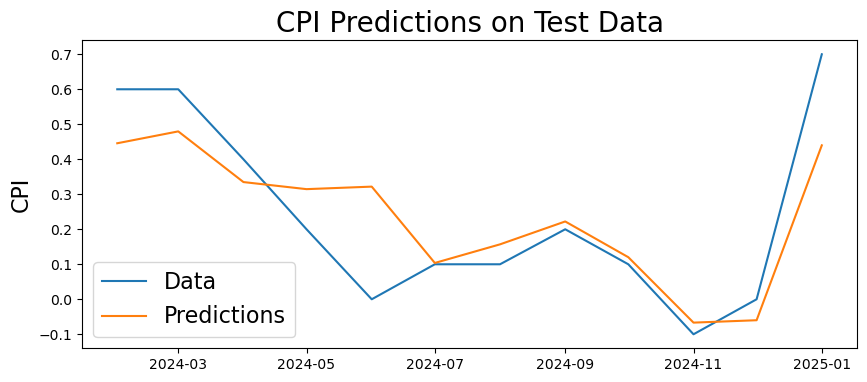

In [6]:
plt.figure(figsize=(10,4))

plt.plot(test.index, test['CPI'], label='Data')
plt.plot(hw_forecast.index, hw_forecast, label='Predictions')

plt.legend(fontsize=16)
plt.title('CPI Predictions on Test Data', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.show()
